In [1]:
# urn and other imports
import unityneuro.render as urn
import numpy as np
import pandas as pd
# ibl imports
from one.api import ONE
one = ONE(base_url='https://alyx.internationalbrainlab.org')
from brainbox.io.one import SpikeSortingLoader
import ibllib.atlas as atlas
CCFAtlas = atlas.AllenAtlas(25)
NeedlesAtlas = atlas.NeedlesAtlas(25)
MRITorontoAtlas = atlas.MRITorontoAtlas(25)
from brainwidemap import bwm_loading
import random
import matplotlib.pyplot as plt

c:\Users\Dan\.conda\envs\iblenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Dan\.conda\envs\iblenv\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Dan\.conda\envs\iblenv\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
ins = bwm_loading.bwm_query(one)

Loading bwm_query results from fixtures/2022_10_update.csv


In [3]:
ins

,pid,eid,probe_name,session_number,date,subject,lab
0,56f2a378-78d2-4132-b3c8-8c1ba82be598,6713a4a7-faed-4df2-acab-ee4e63326f8d,probe00,1,2020-02-18,NYU-11,angelakilab
1,47be9ae4-290f-46ab-b047-952bc3a1a509,56956777-dca5-468c-87cb-78150432cc57,probe01,1,2020-02-21,NYU-11,angelakilab
2,6be21156-33b0-4f70-9a0f-65b3e3cd6d4a,56956777-dca5-468c-87cb-78150432cc57,probe00,1,2020-02-21,NYU-11,angelakilab
3,1e176f17-d00f-49bb-87ff-26d237b525f1,a8a8af78-16de-4841-ab07-fde4b5281a03,probe00,1,2020-01-22,NYU-12,angelakilab
4,701026df-e170-4ca7-88aa-eb0b95ef6ba1,a8a8af78-16de-4841-ab07-fde4b5281a03,probe01,1,2020-01-22,NYU-12,angelakilab
...,...,...,...,...,...,...,...
553,8bf0f1a4-0d8c-4df3-a99e-f7c81c809652,993c7024-0abc-4028-ad30-d397ad55b084,probe01,1,2020-09-16,CSH_ZAD_029,zadorlab
554,5d570bf6-a4c6-4bf1-a14b-2c878c84ef0e,fece187f-b47f-4870-a1d6-619afe942a7d,probe01,1,2020-09-17,CSH_ZAD_029,zadorlab
555,f7c93877-ec05-4091-a003-e69fae0f2fa8,fece187f-b47f-4870-a1d6-619afe942a7d,probe00,1,2020-09-17,CSH_ZAD_029,zadorlab
556,675952a4-e8b3-4e82-a179-cc970d5a8b01,c7bd79c9-c47e-4ea5-aea3-74dda991b48e,probe01,1,2020-09-19,CSH_ZAD_029,zadorlab


# Collect insertion data (planned/micro-manip/histology)

In [238]:
def vec_dist(coord0, coord1):
    return np.sqrt(np.sum(np.power([coord0[0]-coord1[0],coord0[1]-coord1[1],coord0[2]-coord1[2]],2)))
def vec_dist_apml(coord0, coord1):
    return np.sqrt(np.sum(np.power([coord0[0]-coord1[0],coord0[1]-coord1[1]],2)))

def getCoords(ins, coord_transform):
    entry_coords = coord_transform.xyz2ccf(ins.entry, mode='wrap')
    tip_coords = coord_transform.xyz2ccf(ins.entry, mode='wrap')
    angles = [ins.phi, ins.theta, ins.beta]
    depth = vec_dist(entry_coords, tip_coords)
    return (entry_coords, tip_coords, angles, depth)

def traj2coords(traj, coord_transform):
    insertion = atlas.Insertion.from_dict(traj)
    return getCoords(insertion, coord_transform)


In [239]:
prov_planned = 'planned'
prov_mm = 'Micro-manipulator'
prov_ephys = 'Ephys aligned histology track'

bwm_planned = one.alyx.rest('trajectories', 'list', provenance=prov_planned,
                          project='ibl_neuropixel_brainwide_01', use_cache=False)
bwm_mm = one.alyx.rest('trajectories', 'list', provenance=prov_mm,
                          project='ibl_neuropixel_brainwide_01', use_cache=False)
bwm_ephys = one.alyx.rest('trajectories', 'list', provenance=prov_ephys,
                          project='ibl_neuropixel_brainwide_01', use_cache=False)

In [240]:
# re-organize data into a dictionary
data = {}
for i, row in ins.iterrows():
    data[row['pid']] = {}
    
for traj in bwm_planned:
    pid = traj['probe_insertion']
    
    if pid in data.keys():
        data[pid]['planned'] = traj
        
for traj in bwm_mm:
    pid = traj['probe_insertion']
    
    if pid in data.keys():
        data[pid]['micro-manip'] = traj
        
for traj in bwm_ephys:
    pid = traj['probe_insertion']
    
    if pid in data.keys():
        data[pid]['ephys'] = traj

traj_types = ['planned','micro-manip','ephys']
atlas_opts = [CCFAtlas, MRITorontoAtlas, NeedlesAtlas]
atlas_types = ('ccf','mri','needles')

In [241]:
# re-organize all PIDs into dictionaries with sub-dictionaries containing the tip, entry, angles, and depth for each insertion type
traj_data = {}

for pid in data.keys():  
  tdata = data[pid]

  traj_data[pid] = {}

  for type in traj_types:
    if type in tdata.keys():
      traj_data[pid][type] = {}
      for i, c_atlas in enumerate(atlas_opts):
        traj_data[pid][type][atlas_types[i]] = traj2coords(tdata[type], c_atlas)


In [220]:
# fix flipped DV axis in sessions
for pid in traj_data.keys():
  type = 'micro-manip'
  if type in traj_data[pid]:
    for atlas_type in traj_data[pid][type].keys():
      (ecoord, tcoord, angles, depth) = traj_data[pid][type][atlas_type]
      print(ecoord)

[3035. 7900.  332.]
[2898.66386555 7824.83026188  332.        ]
[3035.         7699.90800368  332.        ]
[3910. 6650.  332.]
[3817.78151261 6612.41513094  332.        ]
[3910.         6549.95400184  332.        ]
[3035. 7400.  332.]
[2898.66386555 7339.86420951  332.        ]
[3035.         7239.92640294  332.        ]
[3496. 7400.  501.]
[3382.90756303 7339.86420951  522.96045198]
[3496.         7239.92640294  509.5210084 ]
[3401. 8650.  332.]
[3283.11764706 8552.27934045  332.        ]
[3401.         8389.88040478  332.        ]
[3393.1 7150.   549. ]
[3274.81932773 7097.38118332  577.19774011]
[3393.1        7009.93560258  559.94117647]
[3495.9 8900.   500.9]
[3382.80252101 8794.76236663  522.84745763]
[3495.9        8619.87120515  509.41596639]
[4426.2 6149.9  502. ]
[4360.00840336 6127.35208535  524.09039548]
[4426.2        6089.88040478  510.57142857]
[4037.7 5850.8 1626.9]
[3951.92016807 5837.24539282 1795.16384181]
[4037.7        5814.71941122 1692.18907563]
[6217.  5150.  1

# Run comparisons

In [221]:
def compare_needles_mri_ccf(pid_data):
  # pull the micro-manip and ephys coordinates
  # for mm get the ccf and mri coordinates
  # for ephys just get the ccf coordinate (the rest are not real)
  if 'micro-manip' in pid_data.keys() and 'ephys' in pid_data.keys():
    mm_entry_ccf = pid_data['micro-manip']['ccf'][0]
    mm_entry_mri = pid_data['micro-manip']['mri'][0]
    ephys_entry_ccf = pid_data['ephys']['ccf'][0]
    # compute the distances
    ccf_dist = vec_dist(mm_entry_ccf, ephys_entry_ccf)
    mri_dist = vec_dist(mm_entry_mri, ephys_entry_ccf)
    
    return (ccf_dist, mri_dist)
  else:
    return (np.nan, np.nan)

In [222]:
ccf_dists = []
mri_dists = []

for pid in traj_data.keys():
  pid_data = traj_data[pid]
  (ccf_dist, mri_dist) = compare_needles_mri_ccf(pid_data)
  ccf_dists.append(ccf_dist)
  mri_dists.append(mri_dist)

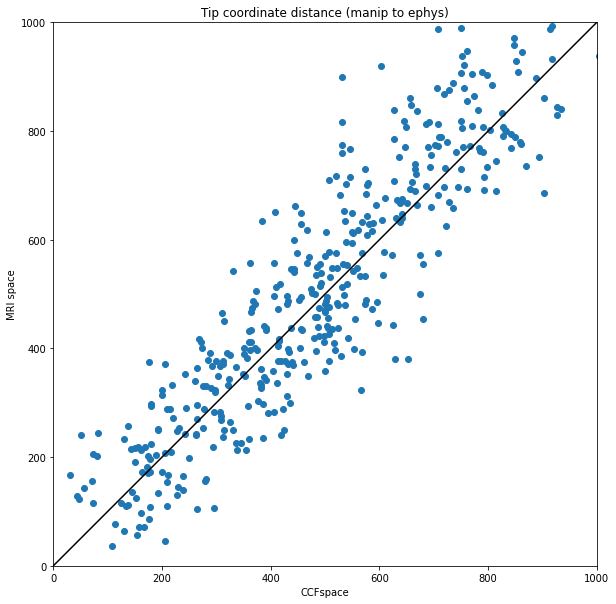

In [270]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
plt.title("Tip coordinate distance (manip to ephys)")
plt.plot(ccf_dists,mri_dists,'o')
plt.plot([0,1000],[0,1000],'-k')
plt.xlim([0, 1000])
plt.ylim([0, 1000])
plt.xlabel('CCFspace')
plt.ylabel('MRI space')
ax.set_aspect('equal', adjustable='box')

(0.0, 1000.0)

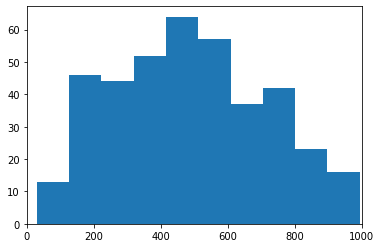

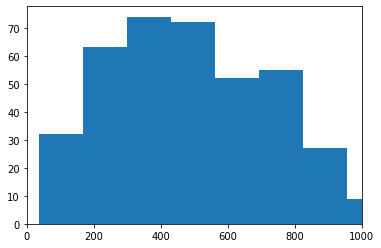

In [210]:
ccf_dists = np.array(ccf_dists)
mri_dists = np.array(mri_dists)
plt.hist(ccf_dists[np.array(ccf_dists)<1000])
plt.xlim([0, 1000])
plt.figure()
plt.hist(mri_dists[np.array(ccf_dists)<1000])
plt.xlim([0, 1000])

In [165]:
print(np.nanmedian(ccf_dists[ccf_dists<1000]))
print(np.nanmedian(mri_dists[ccf_dists<1000]))

497.7675529957454
487.20691972208465


In [248]:
# test code
print(CCFAtlas.xyz2ccf([0,0,0]))
print(CCFAtlas.xyz2ccf([0,0.005,0]))
# needles
print(NeedlesAtlas.xyz2ccf([0,0,0]))
print(NeedlesAtlas.xyz2ccf([0,0.005,0]))
# mri
print(MRITorontoAtlas.xyz2ccf([0,0,0]))
print(MRITorontoAtlas.xyz2ccf([0,0.005,0]))

[5739. 5400.  332.]
[5739.  400.  332.]
[5739. 5400.  332.]
[5739.          800.18399264  332.        ]
[5739. 5400.  332.]
[5739.          550.33947624  332.        ]


# Plot all insertions on one map

2cbb5bc7-edbd-431e-a931-21e466d20dec
('2cbb5bc7-edbd-431e-a931-21e466d20dec', array([ 7992., 11050.,   332.]))
810416d1-ce3c-4b2e-a827-6cdc65c8cd5c
('810416d1-ce3c-4b2e-a827-6cdc65c8cd5c', array([5739., 5400.,  332.]))
f865ea6c-6288-4a77-9a94-ef740166e9c7
('f865ea6c-6288-4a77-9a94-ef740166e9c7', array([4115.2, 2648.8,  633.4]))
aec2b14f-5dbc-400b-bf2e-dd13e711e2ff
('aec2b14f-5dbc-400b-bf2e-dd13e711e2ff', array([5739., 5400.,  332.]))
da57bb3a-b0f2-465d-a5fc-cc84341450b0
('da57bb3a-b0f2-465d-a5fc-cc84341450b0', array([5739., 5400.,  332.]))
e6508b9a-9dec-47d7-88c7-b0a72c7d1134
('e6508b9a-9dec-47d7-88c7-b0a72c7d1134', array([2770.6, 8646.5, 1582.6]))


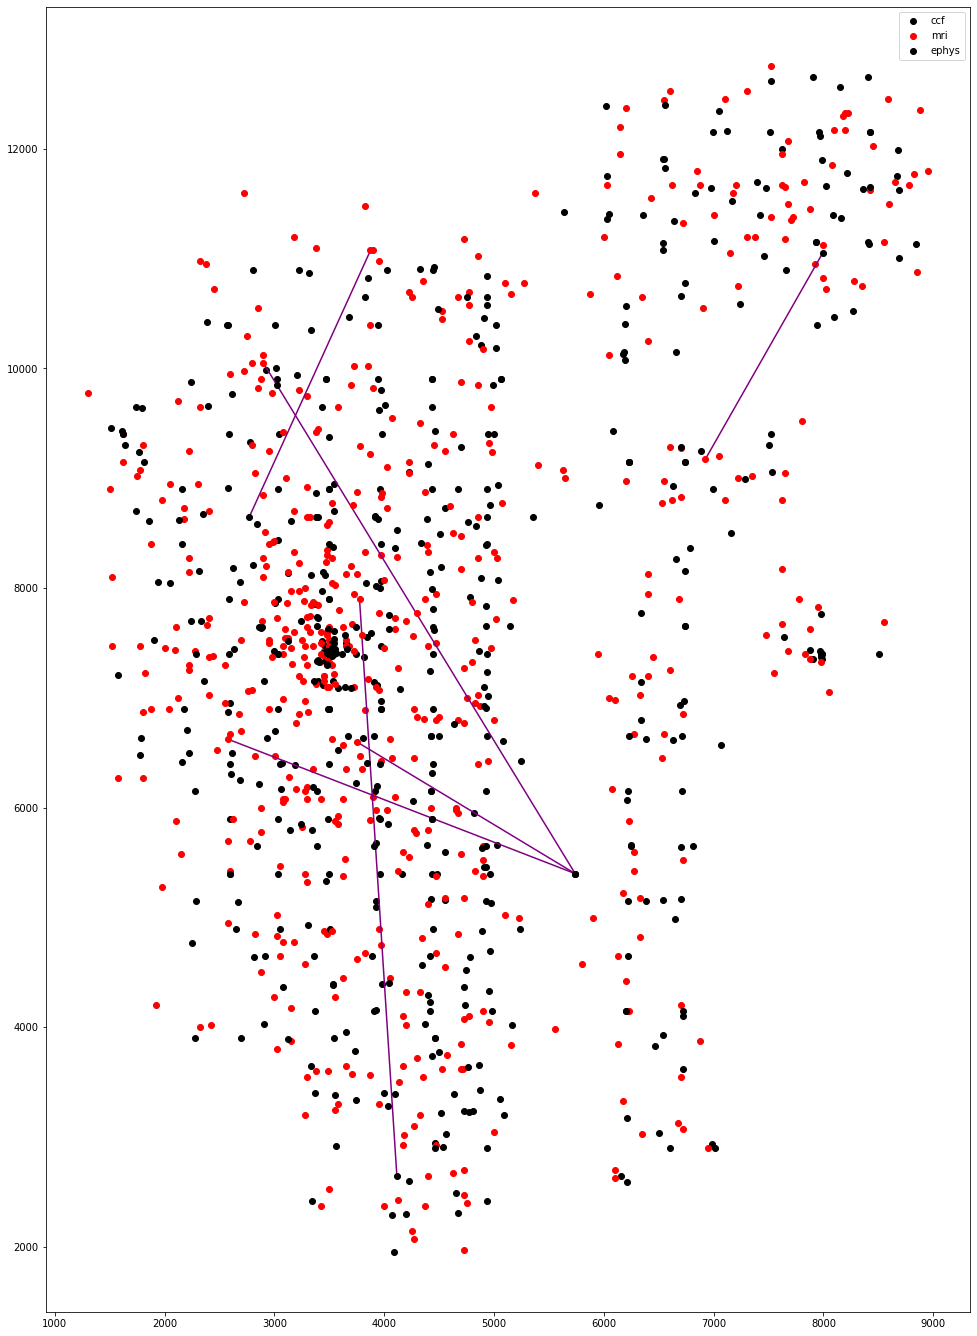

In [267]:
fig = plt.figure(figsize=(33,24))
ax = fig.add_subplot()
ax.set_aspect('equal', adjustable='box')

for pid in traj_data.keys():
  pid_data = traj_data[pid]
  # get the micro-manipulator coordinate in CCF and MRI
  if 'micro-manip' in pid_data.keys():
    mm_entry_ccf = pid_data['micro-manip']['ccf'][0]
    mm_entry_mri = pid_data['micro-manip']['needles'][0]
    # get the ephys coordinate
    ephys_entry = pid_data['ephys']['ccf'][0]

    ccf_dist = vec_dist_apml(mm_entry_ccf, ephys_entry)
    if (ccf_dist > 2000):
      print(pid)
      # plt.plot([mm_entry_ccf[0], mm_entry_mri[0]], [mm_entry_ccf[1], mm_entry_mri[1]], '-', color='green')
      plt.plot([mm_entry_ccf[0], ephys_entry[0]], [mm_entry_ccf[1], ephys_entry[1]], '-', color='purple')
      print((pid, mm_entry_ccf))

    # plot
    plt.plot(mm_entry_ccf[0],mm_entry_ccf[1],'o',color='black')
    # plt.plot(mm_entry_mri[0],mm_entry_mri[1],'o',color='green')
    plt.plot(ephys_entry[0],ephys_entry[1],'o',color='red')

    # plt.plot([mm_entry_ccf[0], mm_entry_mri[0]], [mm_entry_ccf[1], mm_entry_mri[1]], '-', color='green')
    # plt.plot([mm_entry_ccf[0], ephys_entry[0]], [mm_entry_ccf[1], ephys_entry[1]], '-', color='red')

plt.legend(['ccf','mri','ephys'])

In [264]:
print(data['f865ea6c-6288-4a77-9a94-ef740166e9c7']['micro-manip']['session'])
print(data['aec2b14f-5dbc-400b-bf2e-dd13e711e2ff']['micro-manip']['session'])
print(data['da57bb3a-b0f2-465d-a5fc-cc84341450b0']['micro-manip']['session'])
print(data['e6508b9a-9dec-47d7-88c7-b0a72c7d1134']['micro-manip']['session'])
print(data['2cbb5bc7-edbd-431e-a931-21e466d20dec']['micro-manip']['session'])
print(data['810416d1-ce3c-4b2e-a827-6cdc65c8cd5c']['micro-manip']['session'])

{'subject': 'NR_0021', 'start_time': '2022-06-30T13:52:49.148628', 'number': 2, 'lab': 'steinmetzlab', 'id': '1ca83b26-30fc-4350-a616-c38b7d00d240', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.6.2'}
{'subject': 'ibl_witten_18', 'start_time': '2020-09-02T12:29:50', 'number': 1, 'lab': 'wittenlab', 'id': '4ef13091-1bc8-4f32-9619-107bdf48540c', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2'}
{'subject': 'ibl_witten_26', 'start_time': '2021-01-30T15:53:29.408265', 'number': 1, 'lab': 'wittenlab', 'id': '09394481-8dd2-4d5c-9327-f2753ede92d7', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2'}
{'subject': 'CSH_ZAD_022', 'start_time': '2020-05-19T14:45:35', 'number': 1, 'lab': 'zadorlab', 'id': '8db36de1-8f17-4446-b527-b5d91909b45a', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0'}
{'subject': 'PL017', 'start_time': '2021-11-30T22:08:42.177338', 'number': 1, 'lab': 'hausserlab', 'id': '1b61b7f2-a599-4e40-abd6-3e758d2c9e25', 'task_protocol': '_iblrig_tasks_ephysChoice

# OLD CODE

In [142]:
traj_data = pd.DataFrame(columns=['pid','lab',
                                  'ml_e_p','ap_e_p','dv_e_p',
                                  'ml_t_p','ap_t_p','dv_t_p',
                                  'phi_p','theta_p','depth_p',
                                  'ml_e_m','ap_e_m','dv_e_m',
                                  'ml_t_m','ap_t_m','dv_t_m',
                                  'phi_m','theta_m','depth_m',
                                  'ml_e_e','ap_e_e','dv_e_e',
                                  'ml_t_e','ap_t_e','dv_t_e',
                                  'phi_e','theta_e','depth_e'])
mri_data = pd.DataFrame(columns=['pid','ml_e_m','ap_e_m','dv_e_m',
                                 'ml_t_m','ap_t_m','dv_t_m'])
raw_data = pd.DataFrame(columns=['pid','x_micro','y_micro','z_micro',
                                 'x_ephys','y_ephys','z_ephys'])
ccf_data = pd.DataFrame(columns=['pid','ml_e_m','ap_e_m','dv_e_m',
                                'ml_t_m','ap_t_m','dv_t_m'])

count = 0

except_list = []

for pid in data.keys():        
        
    tdata = data[pid]
    missing = False

    if 'planned' in tdata.keys():
        try:
            (ecoords_p, tcoords_p, angles_p, depth_p) = traj2coords(tdata['planned'], NeedlesAtlas)
        except:
            print(f"{pid} planned values are outside CCF space")
            missing = True
    else:
        print(f"{pid} missing planned")
        missing = True

    if 'micro-manip' in tdata.keys():
        try:
            (ecoords_m, tcoords_m, angles_m, depth_m) = traj2coords(tdata['micro-manip'], NeedlesAtlas)
            (ecoords_m_ccf, tcoords_m_ccf, angles_m_ccf, depth_m_ccf) = traj2coords(tdata['micro-manip'], CCFAtlas)
        except:
            print(f"{pid} micro-manip values are outside CCF space")
            except_list.append(pid)
            missing = True
        # also compute the micro-manip -> CCF using the MRI-linear transform
        # we'll do this by hand
        
        try:
            (ecoords_m_mri, tcoords_m_mri, angles_m_mri, depth_m_mri) = traj2coords(tdata['micro-manip'], MRITorontoAtlas)
        except:
            print(f"{pid} micro-manip values are outside CCF space")
            missing = True

        insertion = atlas.Insertion.from_dict(tdata['micro-manip'])
        entry_mm = insertion.entry*1000000
    else:
        print(f"{pid} missing micro-manip")
        missing = True

    if 'ephys' in tdata.keys():
        try:
            (ecoords_e, tcoords_e, angles_e, depth_e) = traj2coords(tdata['ephys'], CCFAtlas)
        except:
            print(f"{pid} ephys values are outside CCF space")
            missing = True

        insertion = atlas.Insertion.from_dict(tdata['ephys'])
        entry_ephys = insertion.entry*1000000
    else:
        print(f"{pid} missing ephys")
        missing = True

    if missing:
        continue

    traj_data.loc[count] = [pid,tdata['planned']['session']['lab'],
                        ecoords_p[0],ecoords_p[1],ecoords_p[2],
                        tcoords_p[0],tcoords_p[1],tcoords_p[2],
                        angles_p[0],angles_p[1],depth_p,
                        ecoords_m[0],ecoords_m[1],ecoords_m[2],
                        tcoords_m[0],tcoords_m[1],tcoords_m[2],
                        angles_m[0],angles_m[1],depth_m,
                        ecoords_e[0],ecoords_e[1],ecoords_e[2],
                        tcoords_e[0],tcoords_e[1],tcoords_e[2],
                        angles_e[0],angles_e[1],depth_e]
    mri_data.loc[count] = [pid,
                           ecoords_m_mri[0], ecoords_m_mri[1], ecoords_m_mri[2],
                           tcoords_m_mri[0], tcoords_m_mri[1], tcoords_m_mri[2]]
    raw_data.loc[count] = [pid,
                           entry_mm[0], entry_mm[1], entry_mm[2],
                           entry_ephys[0], entry_ephys[1], entry_ephys[2]]
    ccf_data.loc[count] = [pid,
                           ecoords_m_ccf[0], ecoords_m_ccf[1], ecoords_m_ccf[2],
                           tcoords_m_ccf[0], tcoords_m_ccf[1], tcoords_m_ccf[2]]
    
    count+=1

traj_data.to_csv('./data/bwm_all_traj.csv',float_format='%.03f')
mri_data.to_csv('./data/bwm_mri_coords.csv',float_format='%.03f')
raw_data.to_csv('./data/bwm_raw_coords.csv',float_format='%.03f')
ccf_data.to_csv('./data/bwm_ccf_coords.csv',float_format='%.03f')

0909252c-3ad0-413f-96f5-7eff885b50aa missing planned
e45a00b1-14a0-4f5e-9ea5-9f76d042b11c missing planned
117f0d28-3cc0-4837-9e3e-46db5bc3e662 missing planned
01864e9d-0dbe-41d4-9e3a-0285348ecfc1 missing planned
a9e83d8a-7c90-4152-abad-53a1ad94d73a missing planned
0777b1bf-964b-49b7-888b-8a6c9df09c3b missing planned
9793c99d-f918-4931-8bba-fdb978bd8e0a missing planned
08ed0b3c-9f94-4c1f-8522-3d42a642a6b0 missing planned
a85b9795-f99c-4c1d-a376-8b5ef095ffd7 missing planned
43d4f889-4b05-44df-8306-ea10f854776f missing planned
50f1512d-dd41-4a0c-b3ab-b0564f0424d7 missing planned
ad256265-03f2-4b4e-954b-0ba0c5cf6707 missing planned
ad256265-03f2-4b4e-954b-0ba0c5cf6707 missing micro-manip
6ad5a0a6-362a-4aec-8743-2e91469b0b62 missing planned
09b62a15-dd8b-4f47-881f-d3f1e5ea5ff4 missing planned
09b62a15-dd8b-4f47-881f-d3f1e5ea5ff4 missing micro-manip
09b62a15-dd8b-4f47-881f-d3f1e5ea5ff4 missing ephys
a6bcfe32-69ce-414f-80bc-495d1b4906af missing planned
e8901184-9f60-4309-bee5-c3c95030550a mis

In [ ]:
except_list

In [ ]:
len(except_list)

# Check if micro-manip outside brain list is the same person

In [ ]:
keep = []
pids = traj_data['pid'].values

for except_pid in except_list:
    keep.append(np.argwhere(except_pid==pids)[0][0])

# Discrepancy 1: Planned identical to micro-manipulator
Analyze the *surface* coordinate and check whether it is identical from planned to micro-manipulator, suggesting the researcher did not enter the real micro-manipulator coordinates

In [ ]:
def disc1(row):
    planned = (row['ml_e_p'], row['ap_e_p'], row['dv_e_p'])
    micro = (row['ml_e_m'], row['ap_e_m'], row['dv_e_m'])
    return planned[0]==micro[0] and planned[1]==micro[1] and planned[2]==micro[2]

In [ ]:
p_identical_mm = []
for i, row in traj_data.iterrows():
    p_identical_mm.append(disc1(row))

traj_data['p_identical_mm'] = p_identical_mm

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [ ]:
print(np.sum(traj_data['p_identical_mm']))

# Discrepancy 2: >1mm distance from micro-manipulator to ephys
Analyze the surface coordinate to check whether the micro-manipulator coordinate is >1mm away from the ephys coordinate
we'll use only ap/ml and ignore dv for this

In [ ]:
def disc2(row):
    micro = (row['ml_e_m'], row['ap_e_m'], row['dv_e_m'])
    ephys = (row['ml_e_e'], row['ap_e_e'], row['dv_e_e'])
    return np.hypot(micro[0]-ephys[0],micro[1]-ephys[1]) > 1000

In [ ]:
mm_ephys_dist = []
for i, row in traj_data.iterrows():
    mm_ephys_dist.append(disc2(row))

traj_data['mm_ephys_dist'] = mm_ephys_dist

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [ ]:
print(np.sum(traj_data['mm_ephys_dist']))

# Discrepancy 3: Flipped DV axis
Check whether the DV coordinate for micro-manipulator and ephys are flipped relative to zero (suggesting the researcher doesn't know which way is which)

In [ ]:
def disc3(row):
    micro = (row['ml_e_m'], row['ap_e_m'], row['dv_e_m'])
    ephys = (row['ml_e_e'], row['ap_e_e'], row['dv_e_e'])
    return (micro[2] > 0 and ephys[2] < 0) or (micro[2] < 0 and ephys[2] > 0)

In [ ]:
flipz = []
for i, row in traj_data.iterrows():
    flipz.append(disc3(row))

traj_data['flipz'] = flipz

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [ ]:
print(np.sum(traj_data['flipz']))

# Discrepancy 4: 0 in micro-manipulator DV position

In [ ]:
def disc4(row):
    micro = (row['ml_e_m'], row['ap_e_m'], row['dv_e_m'])
    return micro[2]==0

In [ ]:
mm_zero_dv = []
for i, row in traj_data.iterrows():
    mm_zero_dv.append(disc4(row))

traj_data['mm_zero_dv'] = mm_zero_dv

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [ ]:
print(np.sum(traj_data['mm_zero_dv']))

# Discrepancy 5: crazy angles

In [ ]:
def angdist(t1, t2):
    d = np.arccos(np.multiply(np.cos(t1), np.cos(t2)) + np.multiply(np.sin(t1),np.sin(t2)))
    return d
    
def disc5(row):
    phi_m = row['phi_m']
    phi_e = row['phi_e']
    return angdist(phi_m,phi_e) > 45

In [ ]:
big_phi_em = []
for i, row in traj_data.iterrows():
    big_phi_em.append(disc5(row))

traj_data['big_phi_em'] = big_phi_em

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [ ]:
print(np.sum(traj_data['big_phi_em']))

# Comparison of Needles vs. CCF coordinates
Load the trajectory data and check whether the Needles transform puts the coordinates closer to the histology coordinates or if they were better left un-transformed.

In [143]:
traj_data = pd.read_csv('./data/bwm_all_traj.csv')
ccf_data = pd.read_csv('./data/bwm_ccf_coords.csv')
mri_data = pd.read_csv('./data/bwm_mri_coords.csv')

In [144]:
def compare_needles_mri_ccf(er, eccf, emri):
    # pass the entry row and the entry ccf row, compare needles against ccf transforms of the micro-manip position
    needles_coord = (er['ml_t_m'],er['ap_t_m'],er['dv_t_m'])
    ephys_coord = (er['ml_t_e'],er['ap_t_e'],er['dv_t_e'])
    ccf_coord = (eccf['ml_t_m'],eccf['ap_t_m'],eccf['dv_t_m'])
    mri_coord = (emri['ml_t_m'],emri['ap_t_m'],emri['dv_t_m'])
    na_dist = vec_dist_apml(needles_coord,ephys_coord)
    ccf_dist = vec_dist_apml(ccf_coord, ephys_coord)
    mri_dist = vec_dist_apml(mri_coord, ephys_coord)
    return (na_dist, ccf_dist, mri_dist)

In [145]:
# compute the needles->ephys and ccf->ephys distances
na_dists = []
ccf_dists = []
mri_dists = []

for i, trow in traj_data.iterrows():
    ccfrow = ccf_data.iloc[i]
    mrirow = mri_data.iloc[i]
    
    (na_dist, ccf_dist, mri_dist) = compare_needles_mri_ccf(trow, ccfrow, mrirow)
    na_dists.append(na_dist)
    ccf_dists.append(ccf_dist)
    mri_dists.append(mri_dist)


In [146]:
diff = np.subtract(na_dists, ccf_dists)

In [147]:
np.median(na_dists)

744.9397405524896

In [148]:
np.median(ccf_dists)

651.5720426240168

Text(0.5, 0, 'CCF to ephys distance (um)')

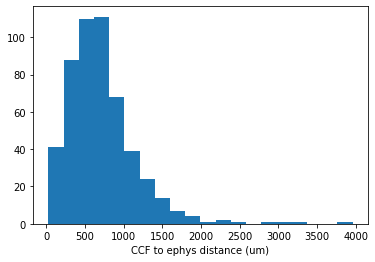

In [149]:
plt.hist(ccf_dists,bins=20)
plt.xlabel('CCF to ephys distance (um)')

(array([ 37.,  91., 116., 103.,  74.,  36.,  28.,  10.,   7.,   5.,   1.,
          1.,   1.,   0.,   2.,   0.,   1.,   0.,   0.,   1.]),
 array([  36.93671432,  243.0503601 ,  449.16400588,  655.27765166,
         861.39129743, 1067.50494321, 1273.61858899, 1479.73223476,
        1685.84588054, 1891.95952632, 2098.0731721 , 2304.18681787,
        2510.30046365, 2716.41410943, 2922.52775521, 3128.64140098,
        3334.75504676, 3540.86869254, 3746.98233831, 3953.09598409,
        4159.20962987]),
 <BarContainer object of 20 artists>)

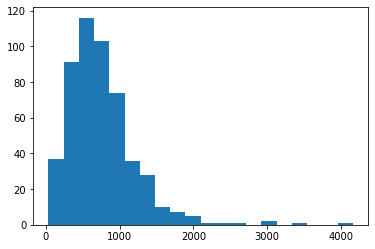

In [150]:
plt.hist(mri_dists, bins=20)

(array([  3.,   4.,  21.,  60.,  97., 121., 105.,  47.,  35.,  21.]),
 array([-496.2266979 , -392.02916265, -287.83162741, -183.63409216,
         -79.43655691,   24.76097834,  128.95851359,  233.15604883,
         337.35358408,  441.55111933,  545.74865458]),
 <BarContainer object of 10 artists>)

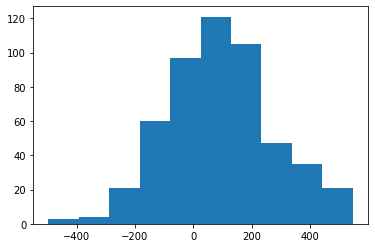

In [151]:
plt.hist(np.subtract(na_dists,ccf_dists))

In [152]:
keep = np.abs(diff)>0
large_difference_data = traj_data.loc[keep]
ldd = large_difference_data

ldm = mri_data.loc[keep]
cdm = ccf_data.loc[keep]

AP flipped: e6508b9a-9dec-47d7-88c7-b0a72c7d1134


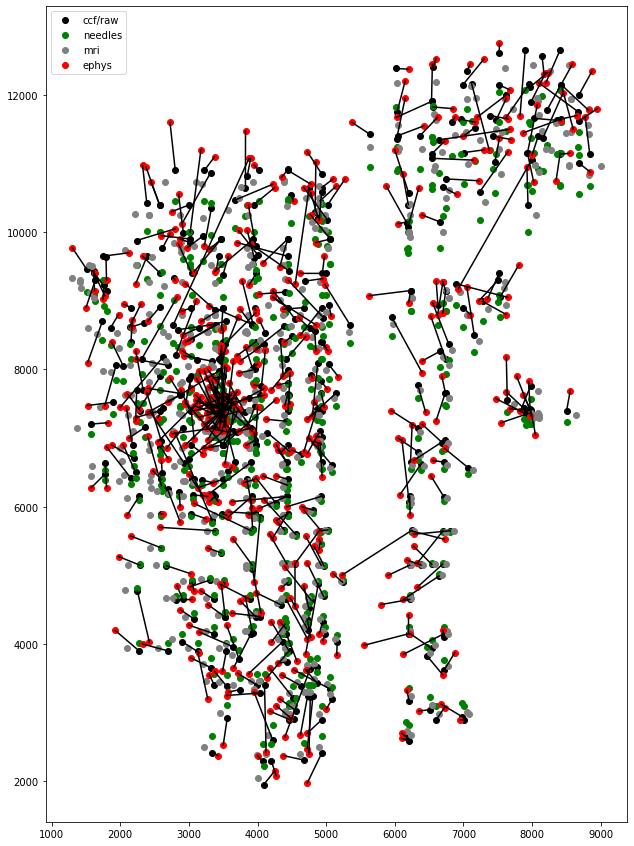

In [153]:
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot()

ap_flip = []
ml_flip = []

plt.plot(cdm['ml_e_m'],cdm['ap_e_m'],'o',color='black')
plt.plot(ldd['ml_e_m'],ldd['ap_e_m'],'o',color='green')
plt.plot(ldm['ml_e_m'],ldm['ap_e_m'],'o',color='grey')
plt.plot(ldd['ml_e_e'],ldd['ap_e_e'],'o',color='red')
ax.legend(['ccf/raw','needles','mri','ephys'])
# ax.legend(['micro-manip entry', 'ephys entry'])

for i, lddr in large_difference_data.iterrows():
    pid = lddr['pid']
    ldmr = mri_data.iloc[i]
    cdmr = ccf_data.iloc[i]
    
    # add a line from ccf to ephys
    xcoord = [cdmr['ml_e_m'],lddr['ml_e_e']]
    ycoord = [cdmr['ap_e_m'],lddr['ap_e_e']]
    if np.abs(ycoord[0]-ycoord[1])>2000:
        print("AP flipped: " + pid)
        ap_flip.append(pid)
    if np.abs(xcoord[0]-xcoord[1])>2000:
        print("ML flipped: " + pid)
        ml_flip.append(pid)
    plt.plot(xcoord,ycoord,'-',color='black')
    
    # add a line from ccf to needles and ccf to mri
   
ax.set_aspect('equal', adjustable='box')

In [ ]:
# find sessions where micro-manip to ephys jumps across midline and/or from back to front
keep = []
pids = ins['pid'].values

for flip_pid in ap_flip:
    keep.append(np.argwhere(flip_pid==pids)[0][0])
    
for flip_pid in ml_flip:
    keep.append(np.argwhere(flip_pid==pids)[0][0])
    
ap_flip_data = ins.iloc[keep]    
ap_flip_data.to_csv('ap_ml_flips.csv')

In [ ]:
ap_flip_data

In [ ]:
fig = plt.figure()
plt.title('Dist mm<->ephys tip (um)')
plt.plot(ccf_dists,na_dists,'o')
plt.plot([0,1200],[0,1200],'-k')
plt.xlim([0, 1200])
plt.ylim([0, 1200])
# plt.title('Dist mm<->ephys entry (um)')
plt.xlabel('Micro-manip as CCF')
plt.ylabel('Micro-manip Needles->CCF')
ax.set_aspect('equal', adjustable='box')

fig = plt.figure()
plt.title('Dist mm<->ephys tip (um)')
# ax = fig.add_subplot(122)
plt.plot(ccf_dists,mri_dists,'o')
plt.plot([0,1200],[0,1200],'-k')
plt.xlim([0, 1200])
plt.ylim([0, 1200])
# plt.title('Dist mm<->ephys entry (um)')
plt.xlabel('Micro-manip as CCF')
plt.ylabel('Micro-manip MRIToronto->CCF')
ax.set_aspect('equal', adjustable='box')

## Compute the NeedlesAtlas to MRIToronto comparison

In [ ]:
def compareNA_MRI(tr, mr):
    needles_coord = (tr['ml_e_m'],tr['ap_e_m'],tr['dv_e_m'])
    mri_coord = (mr['ml_e_m'],mr['ap_e_m'],mr['dv_e_m'])
    ephys_coord = (tr['ml_e_e'],tr['ap_e_e'],tr['dv_e_e'])
    na_dist = vec_dist_apml(needles_coord,ephys_coord)
    mri_dist = vec_dist_apml(mri_coord, ephys_coord)
    return (na_dist, mri_dist)

def compareNA_MRI_tip(tr, mr):
    needles_coord = (tr['ml_t_m'],tr['ap_t_m'],tr['dv_t_m'])
    mri_coord = (mr['ml_t_m'],mr['ap_t_m'],mr['dv_t_m'])
    ephys_coord = (tr['ml_t_e'],tr['ap_t_e'],tr['dv_t_e'])
    na_dist = vec_dist_apml(needles_coord,ephys_coord)
    mri_dist = vec_dist_apml(mri_coord, ephys_coord)
    return (na_dist, mri_dist)

In [ ]:
# Pull the data from the dataframes, lets start with the basic analysis:
# compute the distance from the NeedlesAtlas CCF entry/tip points and the ephys point
# and compare these with the values from the MRITorontoAtlas
na_dists = []
mri_dists = []

for i, trow in traj_data.iterrows():
    nrow = mri_data.iloc[i]
    
    (na_dist, mri_dist) = compareNA_MRI_tip(trow, nrow)
    na_dists.append(na_dist)
    mri_dists.append(mri_dist)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(na_dists,mri_dists,'o')
plt.plot([0,1200],[0,1200],'-k')
plt.xlim([0, 1200])
plt.ylim([0, 1200])
plt.xlabel('NeedlesAtlas to Ephys APML distance (um)')
plt.ylabel('MRITorontoAtlas to Ephys APML distance (um)')
ax.set_aspect('equal', adjustable='box')

In [ ]:
np.median(na_dists)

In [ ]:
np.median(mri_dists)

In [ ]:
plt.hist(np.subtract(na_dists,mri_dists),bins=100)
plt.title('APML Distances between micro-manipulator and ephys')
plt.xlabel('NeedlesAtlas to ephys distance minus MRITorontoAtlas to ephys distance (um)')

# Compute the transform using micro-manipulator coordinates

In [ ]:
raw_data = pd.read_csv('bwm_raw_coords.csv')

In [ ]:
raw_data

In [ ]:
def compute_transform(row):
    # use only ap/ml for now
    bregma_dist = np.sqrt(row['x_ephys']**2+row['y_ephys']**2)
    x_scale = row['x_micro']/row['x_ephys']
    y_scale = row['y_micro']/row['y_ephys']
    # z_scale = row['z_micro']/row['z_ephys']
    z_scale = 0
    return (x_scale, y_scale, z_scale, bregma_dist)

In [ ]:
x_scale = []
y_scale = []
z_scale = []
bregma = []
for i, row in raw_data.iterrows():
    try:
        (x,y,z,b) = compute_transform(row)
        x_scale.append(x)
        y_scale.append(y)
        z_scale.append(z)
        bregma.append(b)
    except:
        pass

In [ ]:
print((np.median(x_scale), np.median(y_scale)))

In [ ]:
plt.plot(bregma,x_scale,'o')

# Individual mouse probe-matching analysis
Check whether in one mouse we think that the micro-manipulator coordinates are properly matched with the ephys coordinates

In [ ]:
umice = np.unique(ins['subject'])

In [ ]:
r = lambda: random.randint(0,255)
randHexColor = lambda : '#%02X%02X%02X' % (r(),r(),r())

In [ ]:
for i, mouse in enumerate(umice):
    idx = np.mod(i,25)
    if idx==0:
        fig, axs = plt.subplots(5, 5, figsize=(10,10))
        axs = axs.flatten()
    
    # get all the insertions for this mouse
    pids = ins[ins['subject']==mouse]['pid']
    # get the entry coordinates for micro-manip and ephys for this mouse

    # plt.title(mouse)
    for pid in pids.values:
        mdata = traj_data[traj_data['pid']==pid]
        color = randHexColor()
        axs[idx].plot(mdata['ml_e_m'],mdata['ap_e_m'],'o',color='#ff0000')
        axs[idx].plot(mdata['ml_e_e'],mdata['ap_e_e'],'o',color='#000000')
        coordx = [mdata['ml_e_m'].values,mdata['ml_e_e'].values]
        coordy = [mdata['ap_e_m'].values,mdata['ap_e_e'].values]
        if np.sqrt(np.power(coordx[0]-coordx[1],2)+np.power(coordy[0]-coordy[1],2)) > 1000:
            print(mouse + ': ' + pid)
        axs[idx].plot(coordx,coordy,'-',color="#00ff00")
    axs[idx].title.set_text(mouse)
    axs[idx].axis('equal')
# plt.xlim([0,11400])
# plt.ylim([0,13200])
# plt.axis('equal')

# Display data using Urchin

In [ ]:
import random
r = lambda: random.randint(0,255)
randHexColor = lambda : '#%02X%02X%02X' % (r(),r(),r())

In [ ]:
colors = {}
labs = np.unique(traj_data['lab'].values)

for lab in labs:
    colors[lab] = randHexColor()

In [ ]:
urn.setup()

In [ ]:
# VIEW 1: Planned insertions
urn.clear()
count = 0

for i, row in traj_data.iterrows():
    probename = 'p'+str(i)
    urn.create_probes([probename])
    urn.set_probe_positions({probename:[row.ml, row.ap, row.dv]})
    urn.set_probe_colors({probename:'#808080'})
    urn.set_probe_angles({probename:[row.phi, row.theta, 0]})
    urn.set_probe_size({probename:[0.07,3.84,0.02]})

# # for some reason 'root' doesn't work?
urn.set_area_visibility({8:True})
urn.set_area_material({8:'transparent-unlit'})
urn.set_area_color({8:'#000000'})
urn.set_area_alpha({8:0.025})

In [ ]:
urn.clear()

In [ ]:
np.unique(traj_data['lab'].values)